In [1]:
# %matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np


3.2.2


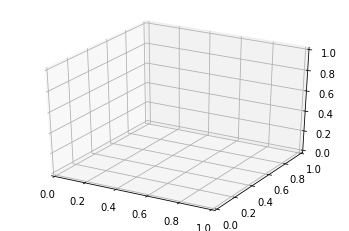

In [2]:
import matplotlib
print(matplotlib.__version__)

fig = plt.figure()
ax = plt.axes(projection='3d')

In [4]:
def update_1d(w, err, jac, eta = 1, q_=0):
    update = jac ** (1 - q) * err
    w -= eta * update
    return w

def update_2d(w, err, jac, eta = 1, q_=0):
    U, A, V = svd_2d(jac)
    update = U * (A ** (1 - q)) @ V @ err
    w -= eta * update
    return w

In [5]:
def svd_2d(A):
#     SVD of 2x2 matrix A:  U and V are orthogonal, D is diagonal, and A=U*D@V
    Su = A @ A.T
    Sw = A.T @ A
#     Find the singular values from U
    SUsum= Su[1,1]+Su[2,2]
    SUdif= sqrt((Su[1,1]-Su[2,2])**2 + 4*Su[1,2]*Su[2,1])
    D = np.diag(np.array([sqrt((SUsum+SUdif)/2), sqrt((SUsum-SUdif)/2)]))  # singular values
#     % Find U such that U *A *A.T*U.T=diag
#     % Find W such that W.T*A.T*A *W=diag
    phi   = 0.5*np.atan2(Su[1,2]+Su[2,1], Su[1,1]-Su[2,2]);   Cos_phi = np.cos(phi);   Sin_phi = np.sin(phi);
    theta = 0.5*np.atan2(Sw[1,2]+Sw[2,1], Sw[1,1]-Sw[2,2]);   Cos_th  = np.cos(theta); Sin_th  = np.sin(theta);
    U = np.array([[Cos_phi, -Sin_phi], [Sin_phi, Cos_phi]])
    W = np.array([[Cos_th,  -Sin_th],  [Sin_th,  Cos_th]])
    V = W @ np.diag(np.sign(np.diag(U.T*A*W)))

    return U,D,V

In [9]:
def shallownet_1d(w, a=1):
    f = a * w             # input-output map
    j = a                 # Jacobian of map
    target = 0
    err = f - target
    loss = err ** 2 /2
    return loss, err, j 

def shallownet_2d(w, A = np.array([[1,2],[2,1]]) ):
    f = A @ w             # input-output map
    j = A                 # Jacobian of map
    target = 0
    err = f - target
    loss = (err ** 2 /2).sum(axis=0)
    return loss, err, j 

def deepnet_1d(w, d=1):
    f = w ** d              # input-output map
    j = d * w ** (d-1)      # Jacobian of map
    target = 1
    err = f - target
    loss = err ** 2 /2
    return loss, err, j 

In [19]:
def landscape_2d(x1,x2):
    freq = np.exp(np.linspace(-2,3,7)) 
    a = 1/freq 

    y1 = x1;  y2 = x2 
    for i in range(len(freq)):
        y1 += a[i]* np.sin(freq[i]*x2) 
        y2 += a[i]* np.cos(freq[i]*x1) 

    c1 = 0;  s1=0;  c2 = 0;  s2=0 
    for i in range(len(freq)):
        s1 += a[i]* np.sin(freq[i]*y1) 
        c1 += a[i]* np.cos(freq[i]*y1) 
        s2 += a[i]* np.sin(freq[i]*y2) 
        c2 += a[i]* np.cos(freq[i]*y2) 

    z1 = y1 * s2 + c1 * y2  
    z2 = s1 * y2 + y1 * c2  

    loss = z1 ** 2 + z2 ** 2  
    return loss



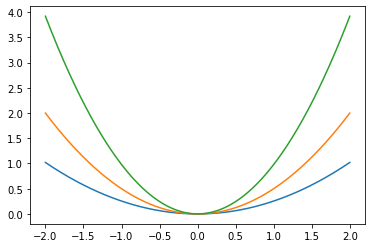

In [13]:
x = np.linspace(-2, 2, 301)
for a in [1/1.4, 1, 1.4]:
    y, _, _ = shallownet_1d(x, a)
    plt.plot(x, y)
    
plt.show()

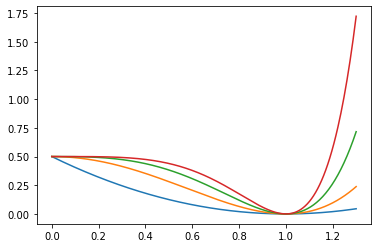

In [7]:
x = np.linspace(0, 1.3, 301)
for d in range(1,5):
    y, _, _ = deepnet_1d(x, d)
    plt.plot(x, y)
    
plt.show()

[[-2. -1.  0.  1.  2. -2. -1.  0.  1.  2. -2. -1.  0.  1.  2. -2. -1.  0.
   1.  2. -2. -1.  0.  1.  2.]
 [-2. -2. -2. -2. -2. -1. -1. -1. -1. -1.  0.  0.  0.  0.  0.  1.  1.  1.
   1.  1.  2.  2.  2.  2.  2.]]


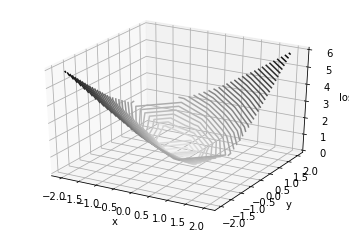

In [8]:
nx = 5
x0 = np.linspace(-2, 2, nx)
x, y = np.meshgrid(x0, x0)
xy = np.concatenate((x.reshape([1,nx**2]),y.reshape([1,nx**2])),axis=0)
print(xy)
z, _, _ = shallownet_2d(xy)
z = z.reshape([nx,nx])

fig = plt.figure()
# plt.contour(x,y,z, 50, cmap='binary')
ax = plt.axes(projection='3d')
ax.contour3D(x,y,np.sqrt(z), 50, cmap='binary')
ax.set_xlabel('x');ax.set_ylabel('y'); ax.set_zlabel('loss');
    
plt.show()

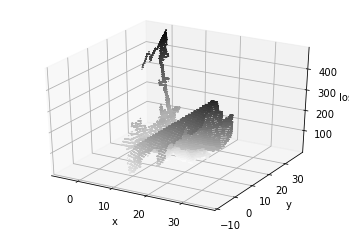

In [22]:
nx = 601  #601
x0 = np.linspace(0,25, nx)

x1,x2 = np.meshgrid (x0, x0)
z = landscape_2d(x1,x2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(x1,x2,np.sqrt(z), 60, cmap='binary')
ax.set_xlabel('x');ax.set_ylabel('y'); ax.set_zlabel('loss');
    
plt.show()